In [192]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid

import nibabel

In [191]:
%matplotlib inline
def show(img):
    
    npimg = img.numpy()
    #print(npimg.shape)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((46,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        sample = {'x':im,'y':target_label} 
        return sample

In [5]:
# # torch.from_numpy()
# train_file_names = unpickling("/scratch/ark576/train_file_names")
# train_label_names = unpickling("/scratch/ark576/train_label_names")
# rand1 = np.arange(len(train_file_names))
# np.random.shuffle(rand1)
# rand1 = rand1[:1000]

# val_file_names = unpickling("/scratch/ark576/val_file_names")
# val_label_names = unpickling("/scratch/ark576/val_label_names")
# rand2 = np.arange(len(val_file_names))
# np.random.shuffle(rand2)
# rand2 = rand2[:250]

# test_file_names = unpickling("/scratch/ark576/test_file_names")
# test_label_names = unpickling("/scratch/ark576/test_label_names")
# rand3 = np.arange(len(test_file_names))
# np.random.shuffle(rand3)
# rand3 = rand3[:3]




In [6]:
file_names = pd.read_csv("all_complete_path.csv")

In [7]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [8]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [9]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [10]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:1000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [11]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=12,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [12]:
inputs = next(iter(dataloader['train']))

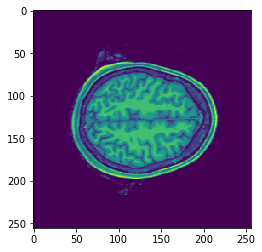

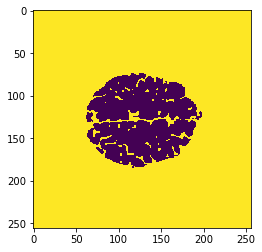

In [13]:
j = 3
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

In [14]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [15]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [16]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,46, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [17]:
voxel_count = pd.read_csv('/cbi/hcp/hcp_seg/brain_segmentation/segment_counts.csv')

In [18]:
wts_num = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [19]:
wts_torch = Variable(torch.from_numpy(wts_num)).cuda()

In [126]:
def dice_loss_2(true1,scores1,mean, epsilon = 1e-4,p = 1):
    N, C, sh1, sh2 = true1.size()
    
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    true = torch.stack(true)
    scores = torch.stack(scores)
    N, C, sh1, sh2 = true.size()
    
    
    preds = F.softmax(scores)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
    mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [127]:
def dice_score(true1,scores1, epsilon = 1e-7):
    N ,C, sh1, sh2 = true1.size()
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    true = torch.stack(true)
    scores = torch.stack(scores)
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*46
    for i in range(46):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*46
    for i in range(46):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [128]:
import time
def train_model(model, optimizer,dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(46)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*46
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * batch_size
                dice_score_batch = dice_score(y,output)

                for j in range(46):
                    run_class_scores[j] = run_class_scores[j] + dice_score_batch[j] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss.item()) 
            for j in range(46):
                score = run_class_scores[j]/data_sizes[phase]
                dice_scores_of_all_class[j][phase].append(score.to(torch.device("cpu")).numpy())
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [129]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 5e-4)

In [131]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,12,
                                                                num_epochs = 20, verbose = True)

Epoch: 0, Phase: train, epoch loss: 0.9926
----------
Epoch: 0, Phase: validate, epoch loss: 0.8976
----------
0
Epoch: 1, Phase: train, epoch loss: 0.6202
----------
Epoch: 1, Phase: validate, epoch loss: 0.5063
----------
1
Epoch: 2, Phase: train, epoch loss: 0.4790
----------
Epoch: 2, Phase: validate, epoch loss: 0.5610
----------
2
Epoch: 3, Phase: train, epoch loss: 0.4217
----------
Epoch: 3, Phase: validate, epoch loss: 0.4557
----------
3
Epoch: 4, Phase: train, epoch loss: 0.3935
----------
Epoch: 4, Phase: validate, epoch loss: 0.3908
----------
4
Epoch: 5, Phase: train, epoch loss: 0.3689
----------
Epoch: 5, Phase: validate, epoch loss: 0.3918
----------
5
Epoch: 6, Phase: train, epoch loss: 0.3530
----------
Epoch: 6, Phase: validate, epoch loss: 0.4995
----------
6
Epoch: 7, Phase: train, epoch loss: 0.3448
----------
Epoch: 7, Phase: validate, epoch loss: 0.3287
----------
7
Epoch: 8, Phase: train, epoch loss: 0.3327
----------
Epoch: 8, Phase: validate, epoch loss: 0.4

In [132]:
torch.save(model.state_dict(), "model4")

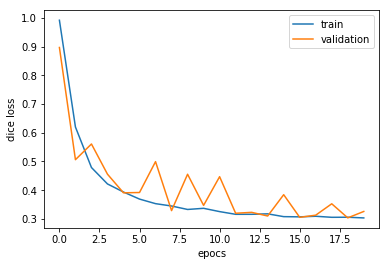

In [133]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

In [83]:
pickling(dice_hist,"model1_dice_hist")

In [141]:
data = next(iter(dataloader["validate"]))

In [142]:
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)

In [143]:
def visualize(image, class_viz, title):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    masked = (p_maxim==class_viz).data.type(torch.cuda.FloatTensor)
    plt.title(title)
    plt.imshow(masked[:,:].cpu().numpy())

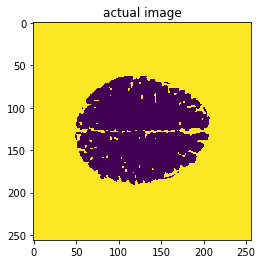

In [145]:
visualize(data['y'][5,:,:,:],0,"actual image") 

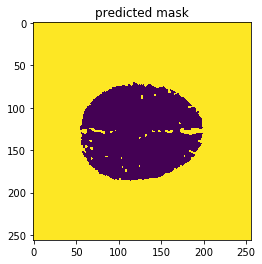

In [146]:
visualize(output[5,:,:,:],0,"predicted mask")

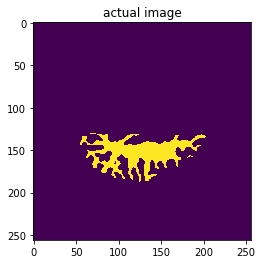

In [147]:
visualize(data['y'][5,:,:,:],1,"actual image") 

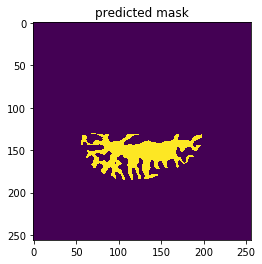

In [148]:
visualize(output[5,:,:,:],1,"predicted mask")

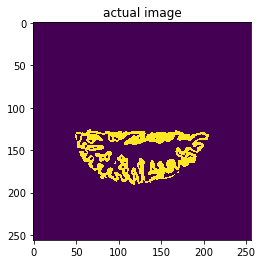

In [151]:
visualize(data['y'][5,:,:,:],2,"actual image") 

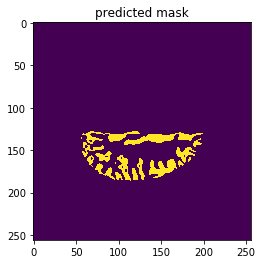

In [153]:
visualize(output[5,:,:,:],2,"predicted mask")

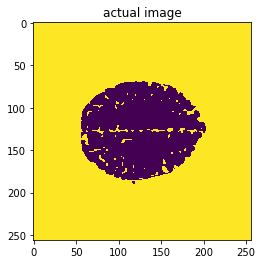

In [158]:
visualize(data['y'][9,:,:,:],0,"actual image") 

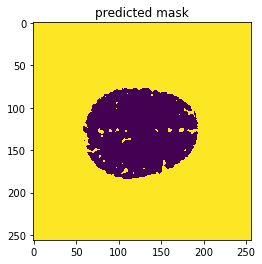

In [157]:
visualize(output[9,:,:,:],0,"predicted mask")

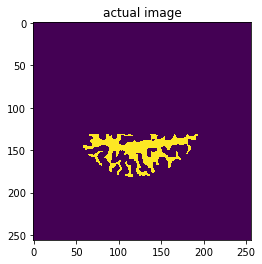

In [159]:
visualize(data['y'][9,:,:,:],1,"actual image") 

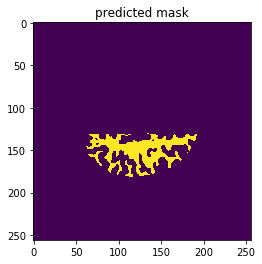

In [160]:
visualize(output[9,:,:,:],1,"predicted mask")

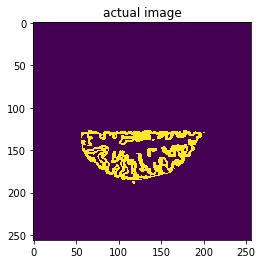

In [161]:
visualize(data['y'][9,:,:,:],2,"actual image") 

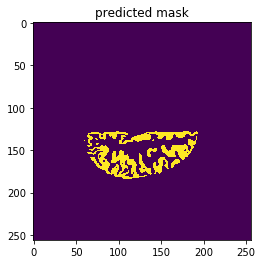

In [162]:
visualize(output[9,:,:,:],2,"predicted mask")

In [220]:
def visualize1(image):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(46):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    #plt.title(title)
    #plt.imshow(masked[:,:].cpu().numpy())
    #print(torch.stack(img).size())
    return torch.stack(img).resize(46,1,256,256).cpu()

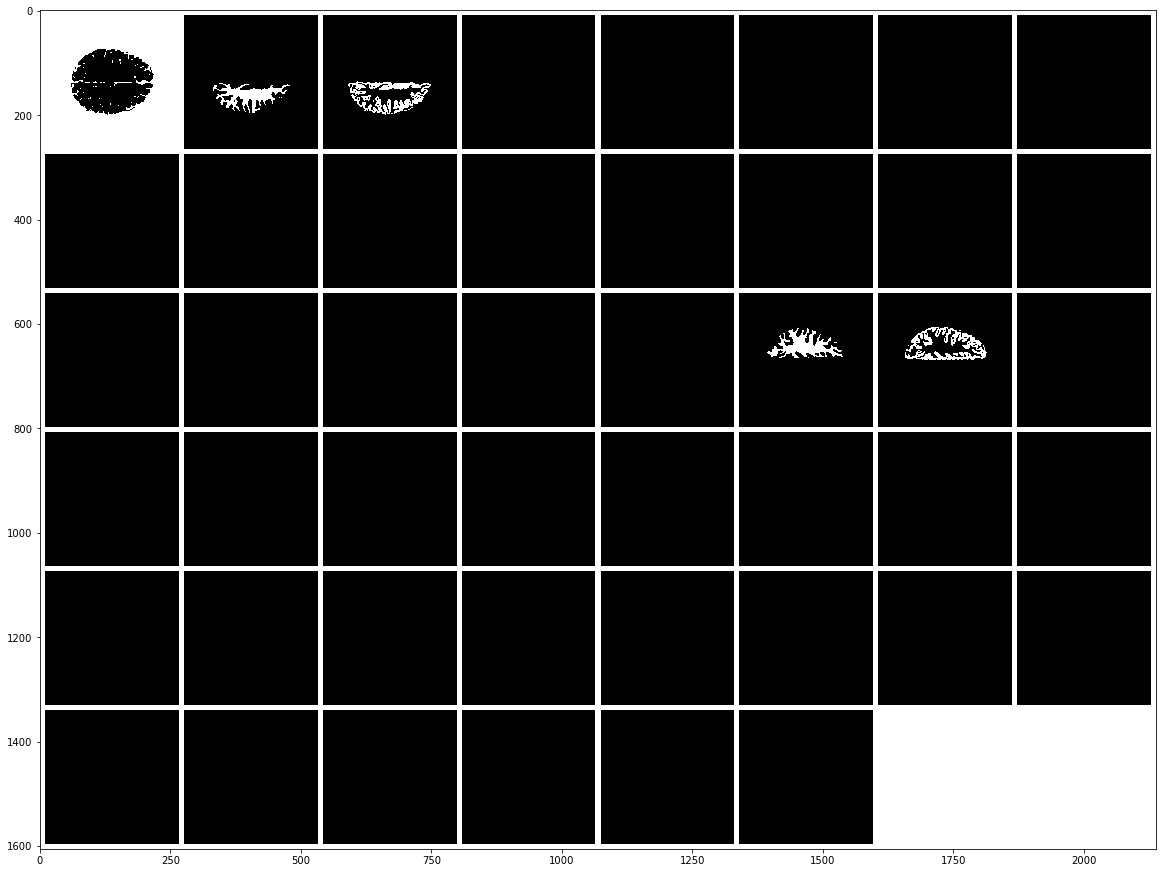

In [226]:
abc = data['y'][5,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1)) 

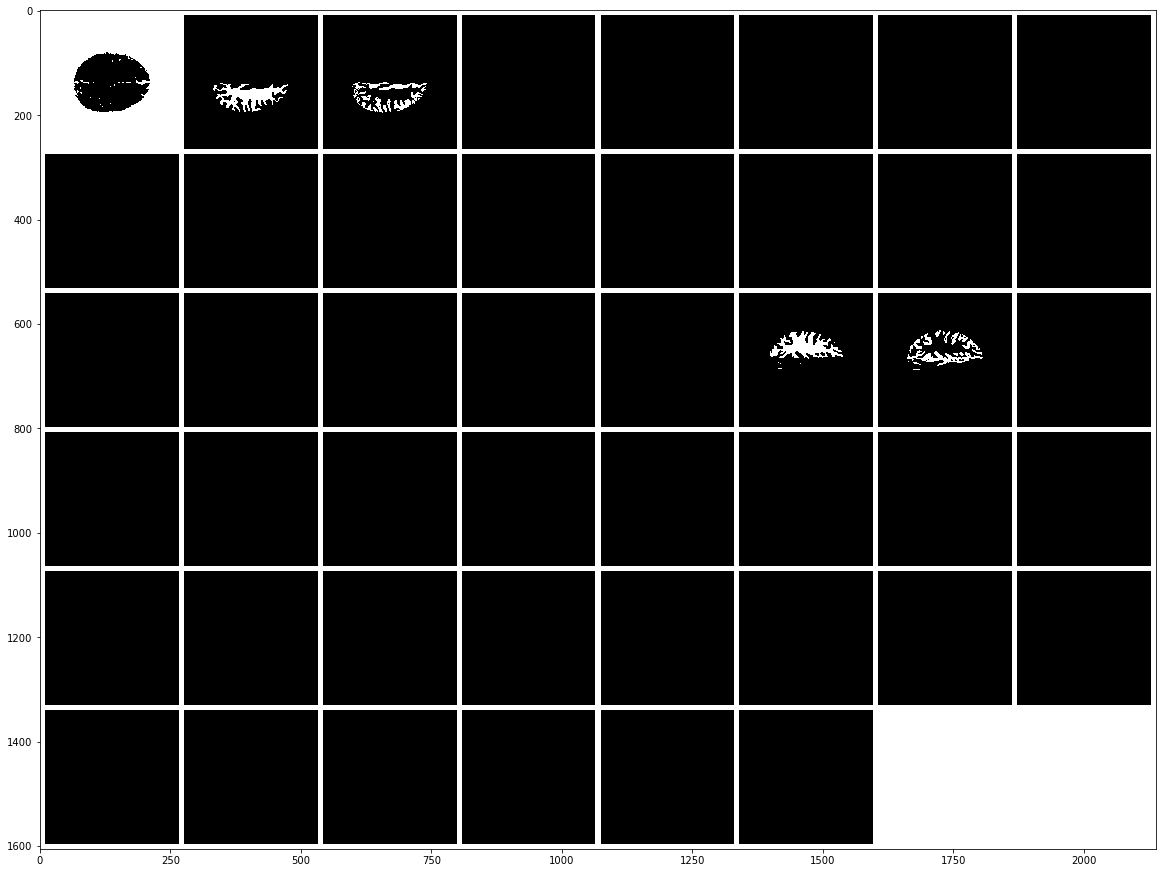

In [227]:
show(make_grid(visualize1(output[5,:,:,:]),padding=10,pad_value=1))

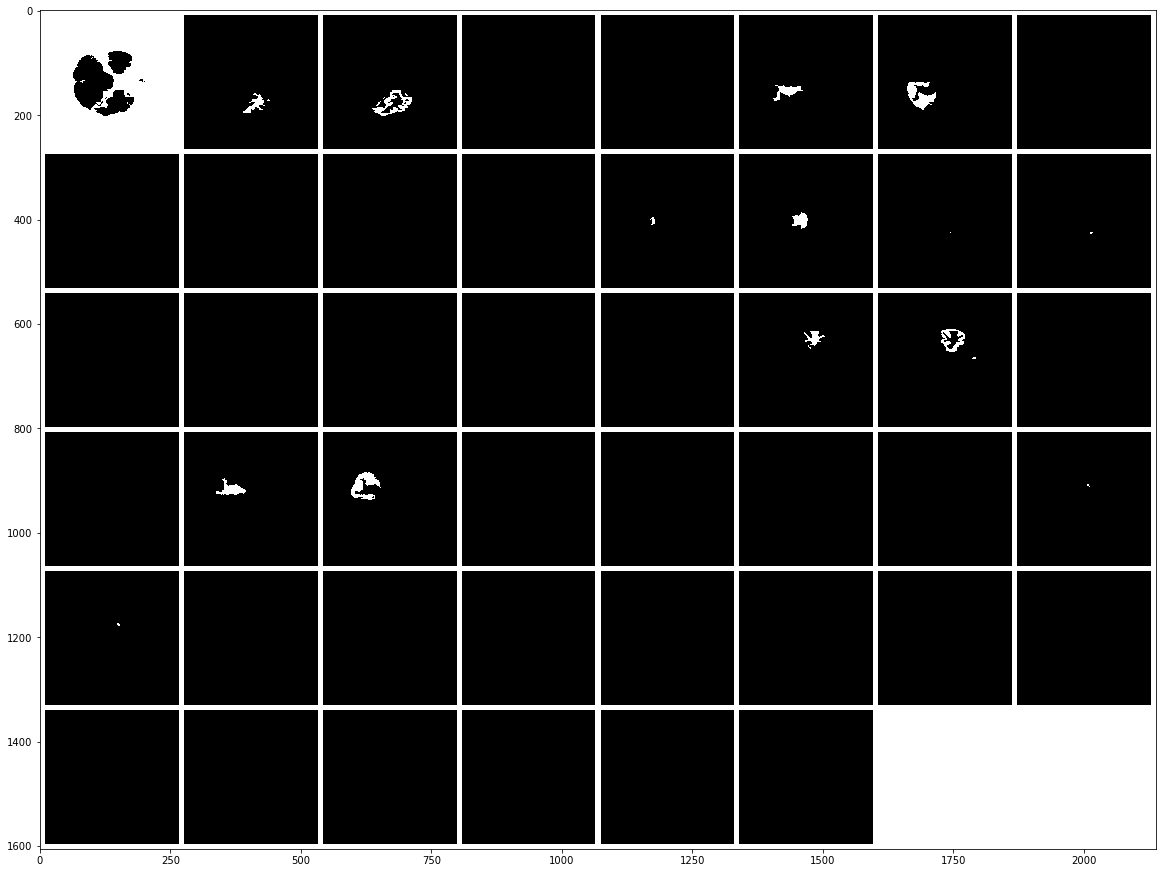

In [232]:
abc = data['y'][10,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1)) 

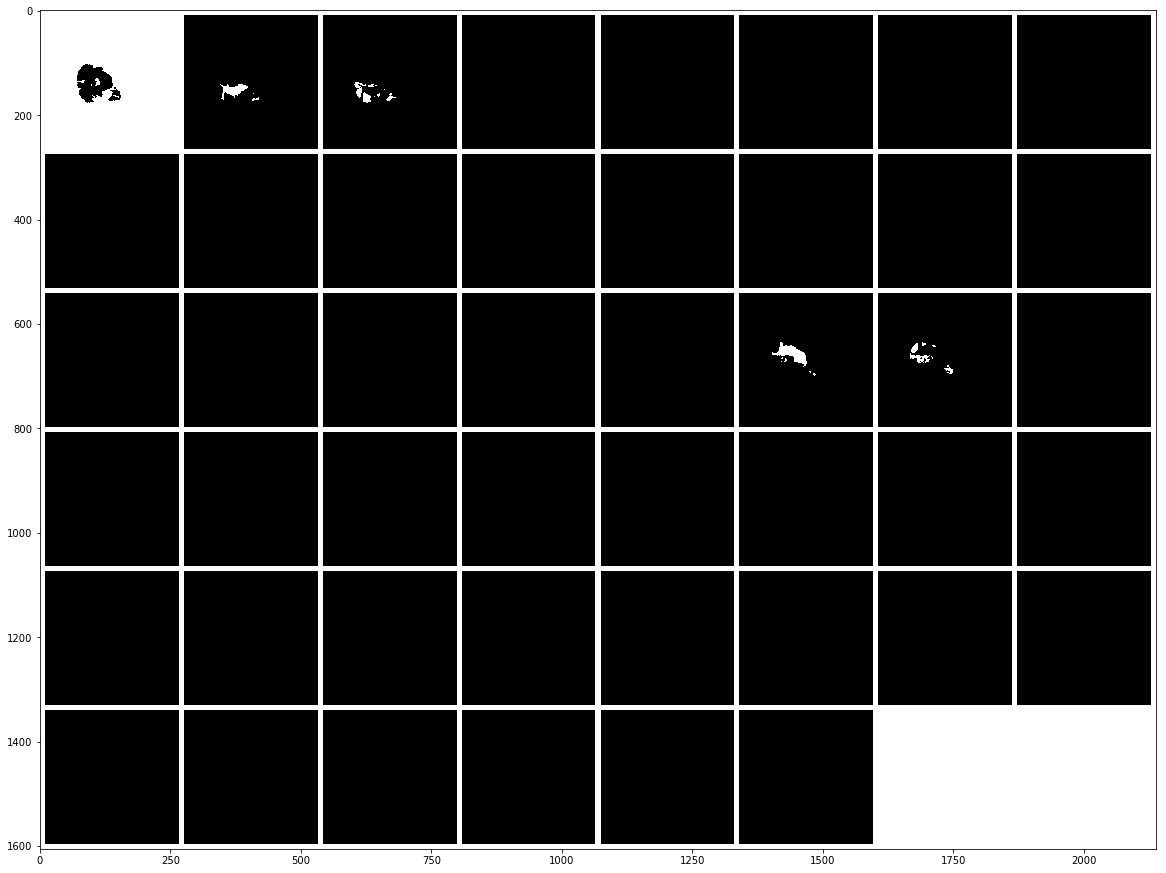

In [233]:
show(make_grid(visualize1(output[10,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


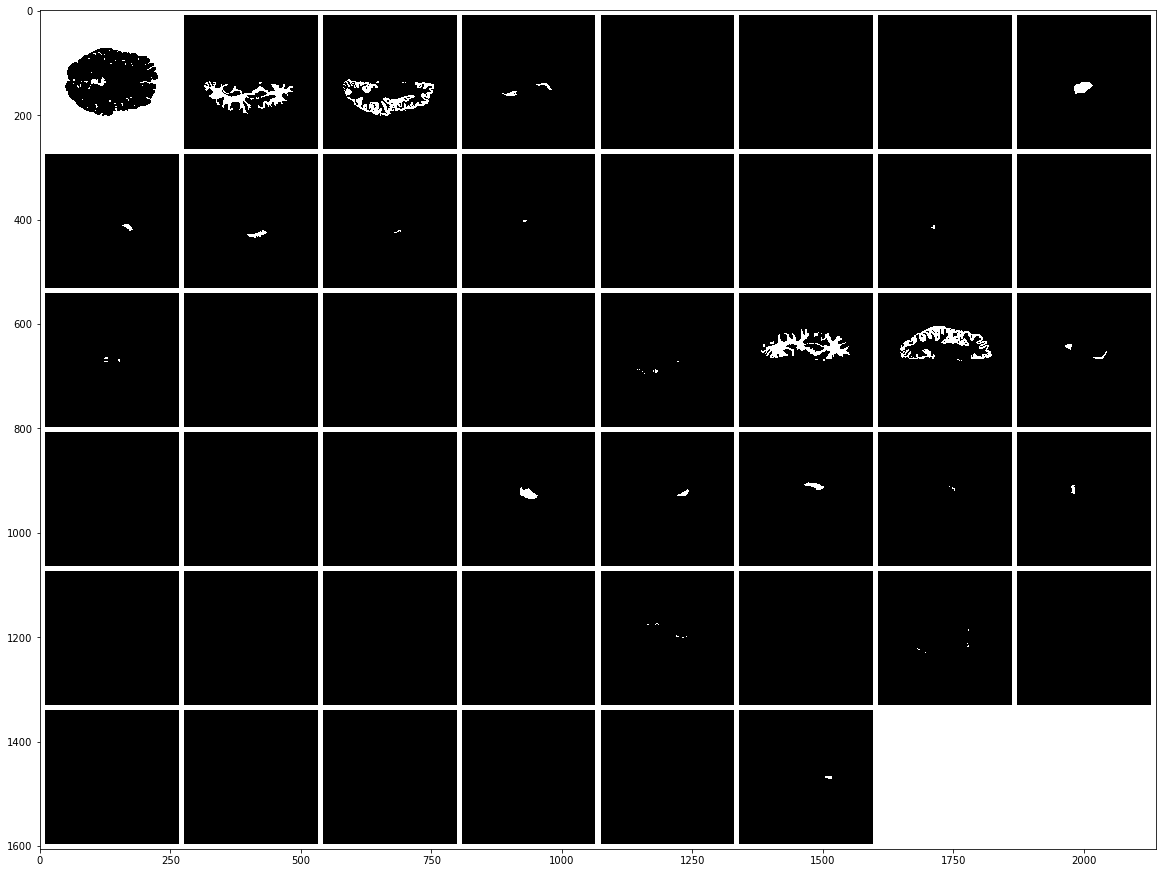

----------------------------------------------------------------------------------------------------
Prediction


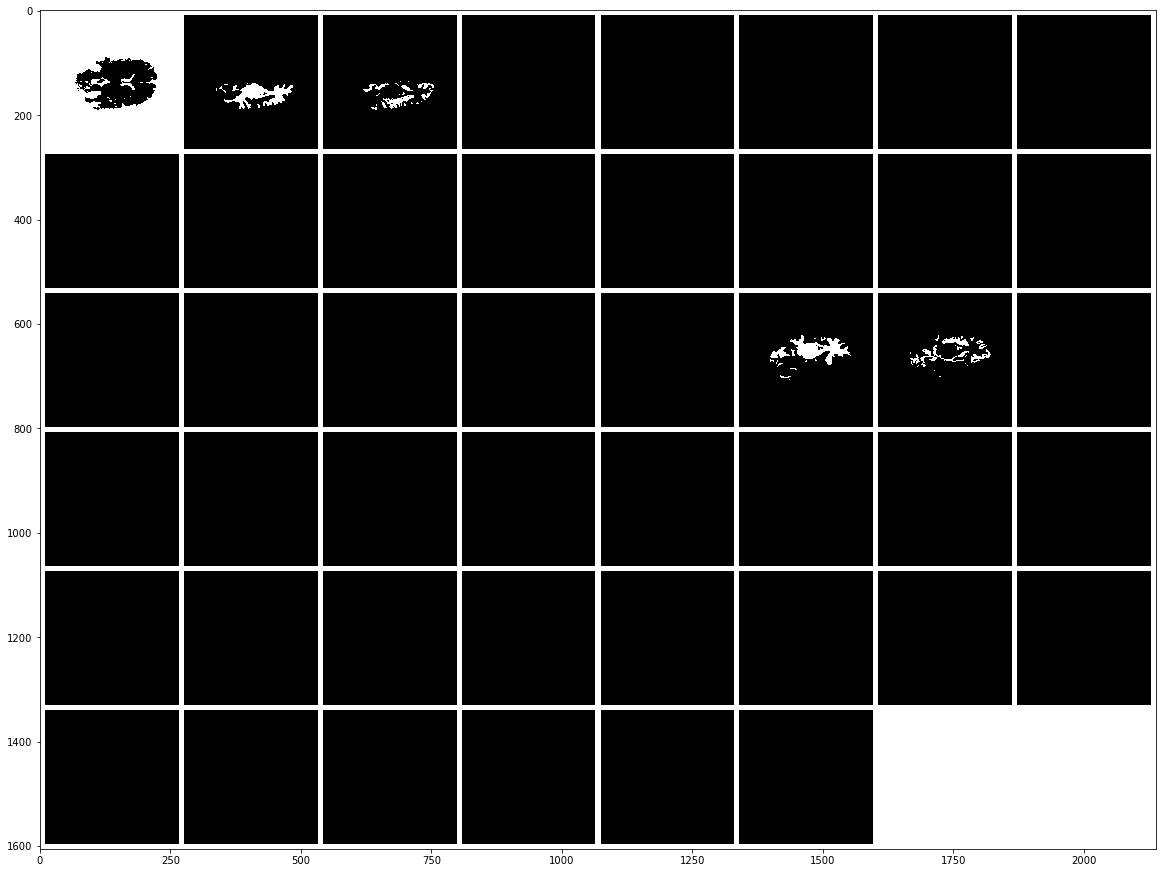

----------------------------------------------------------------------------------------------------
Ground Truth


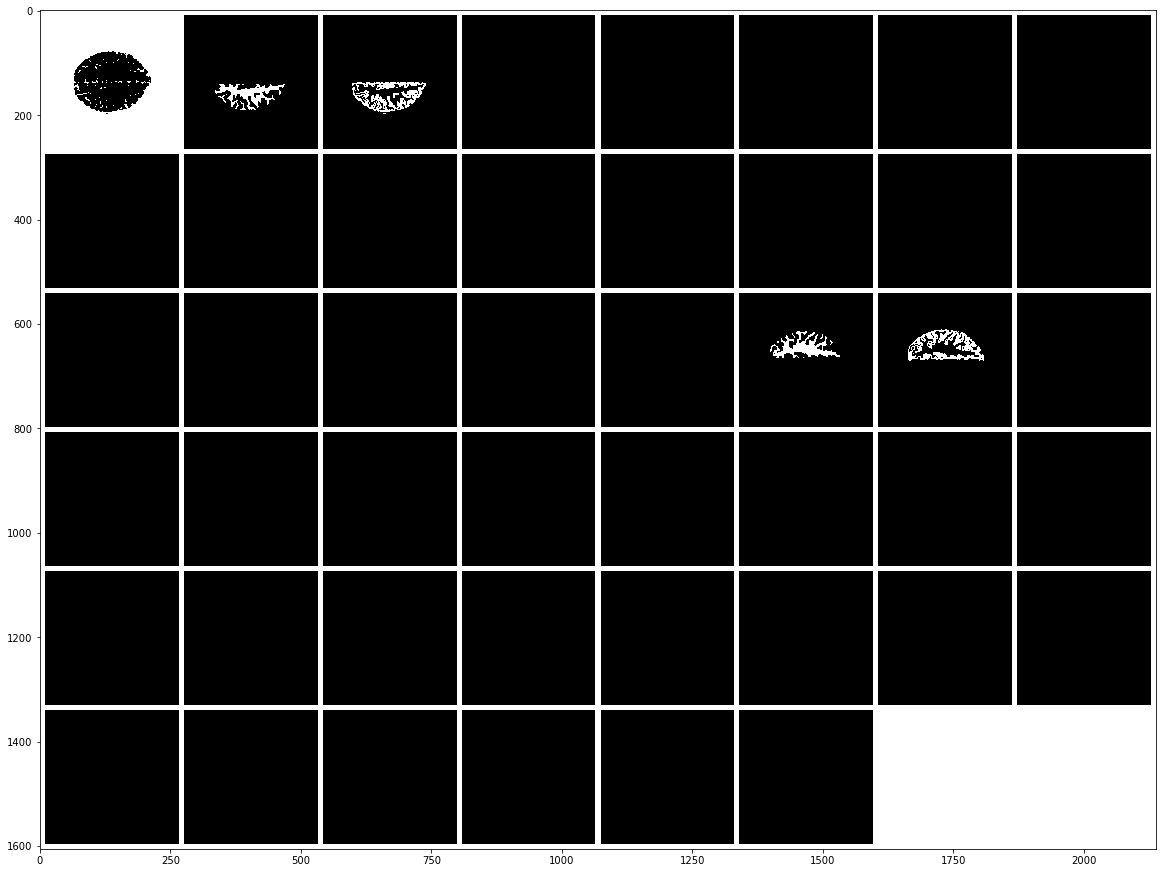

----------------------------------------------------------------------------------------------------
Prediction


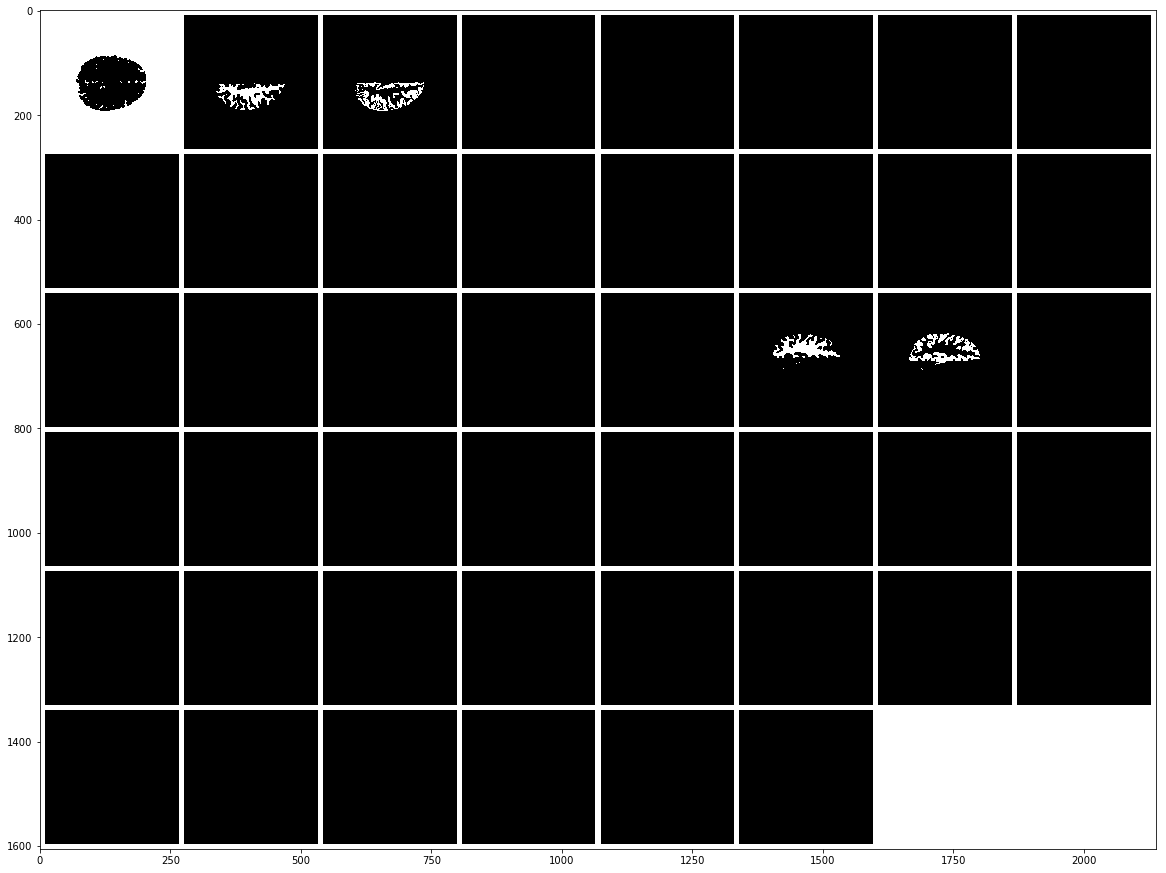

----------------------------------------------------------------------------------------------------
Ground Truth


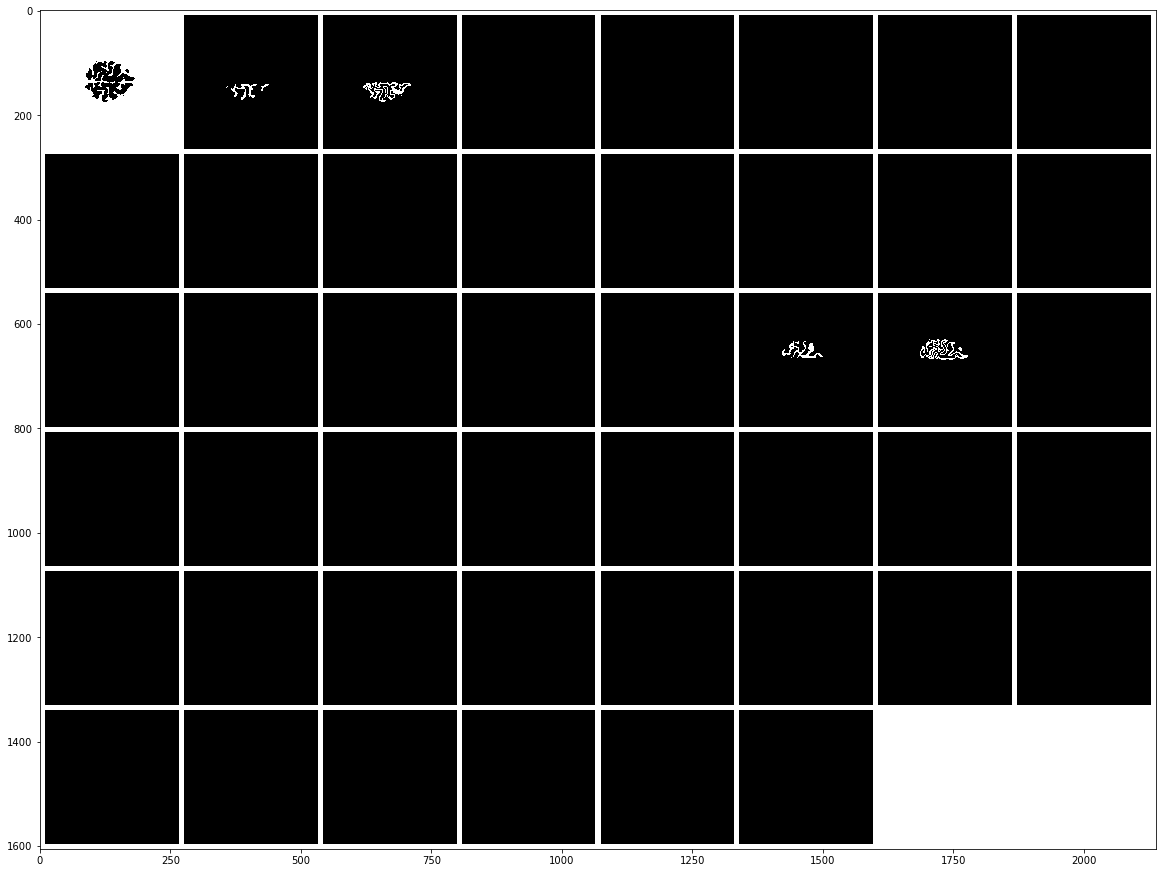

----------------------------------------------------------------------------------------------------
Prediction


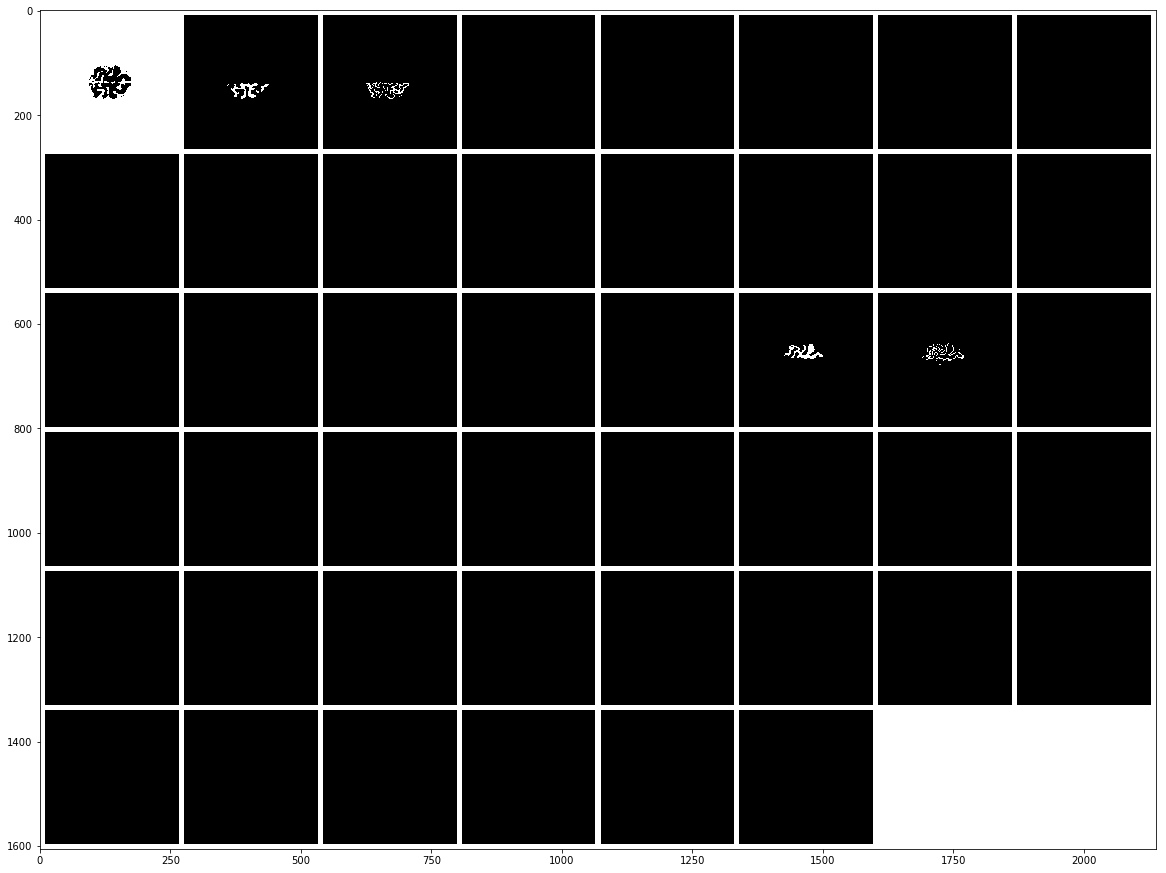

----------------------------------------------------------------------------------------------------
Ground Truth


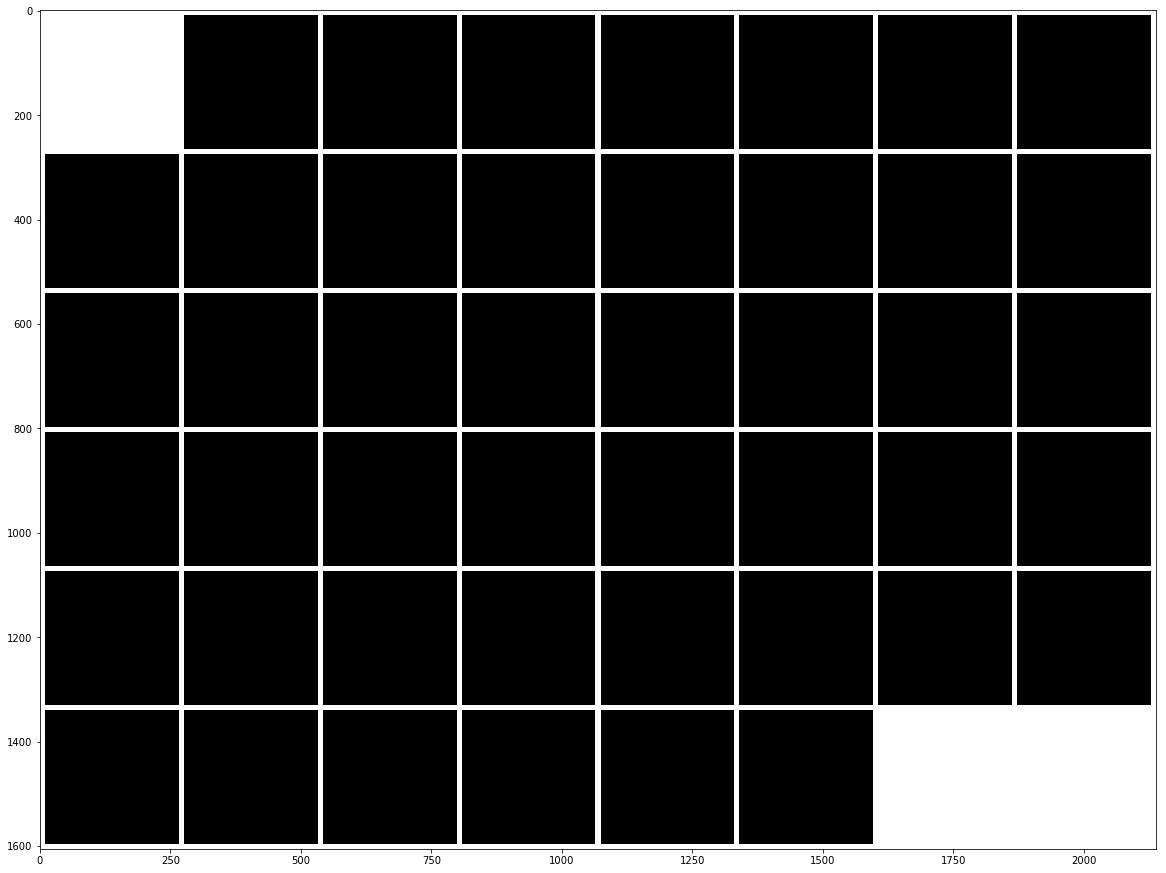

----------------------------------------------------------------------------------------------------
Prediction


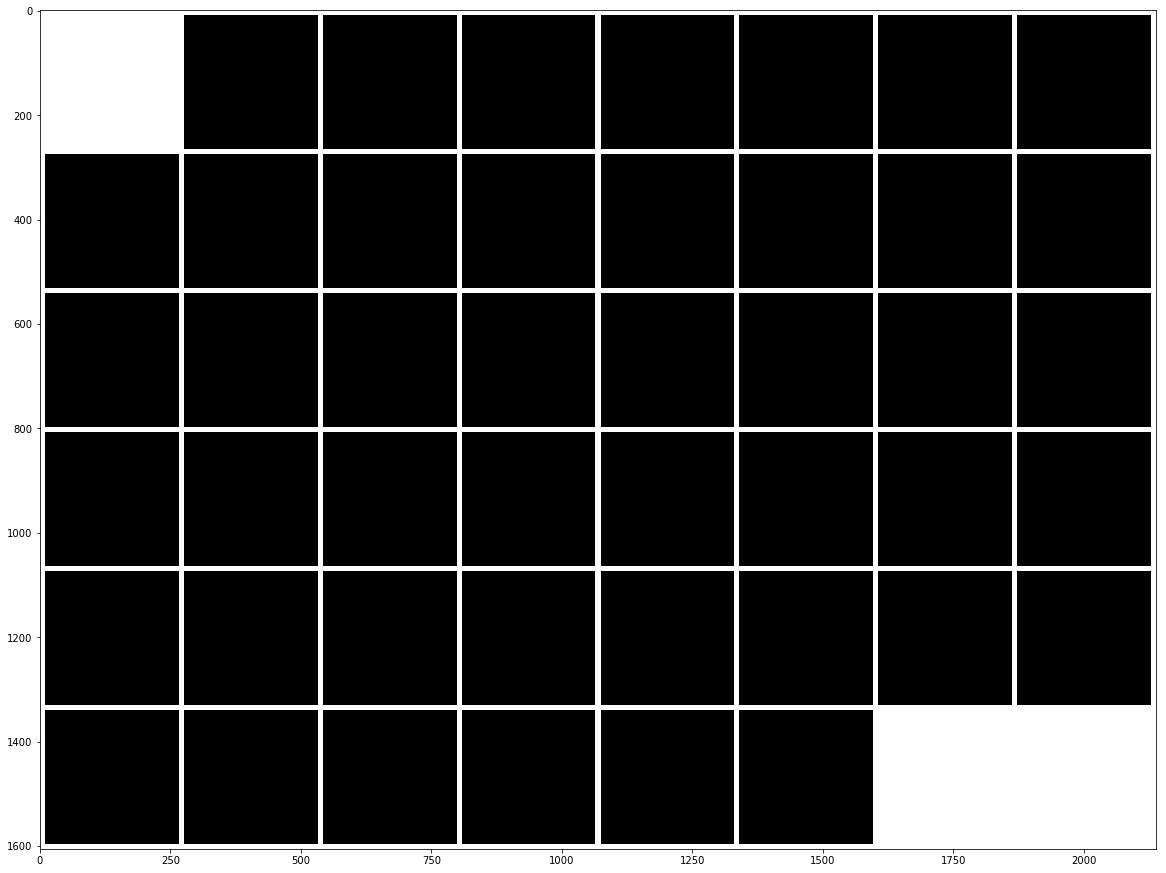

----------------------------------------------------------------------------------------------------
Ground Truth


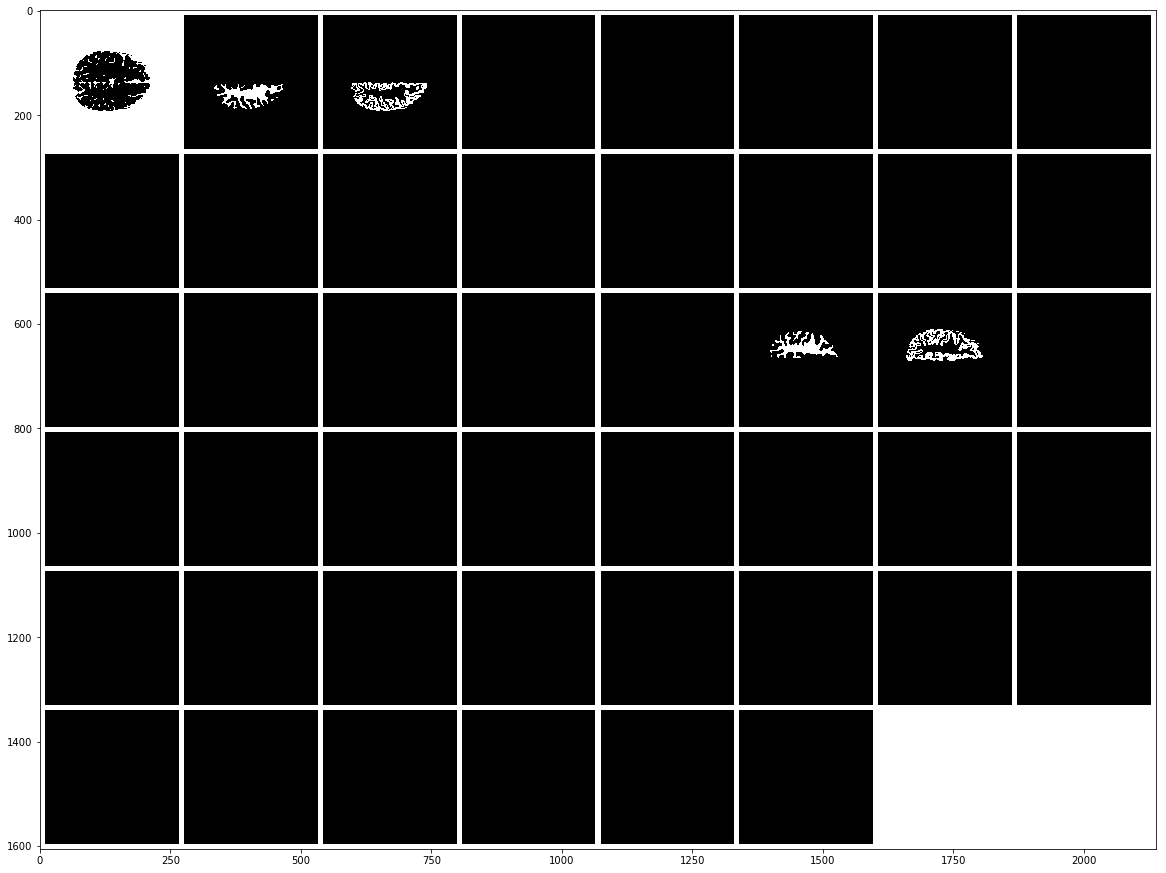

----------------------------------------------------------------------------------------------------
Prediction


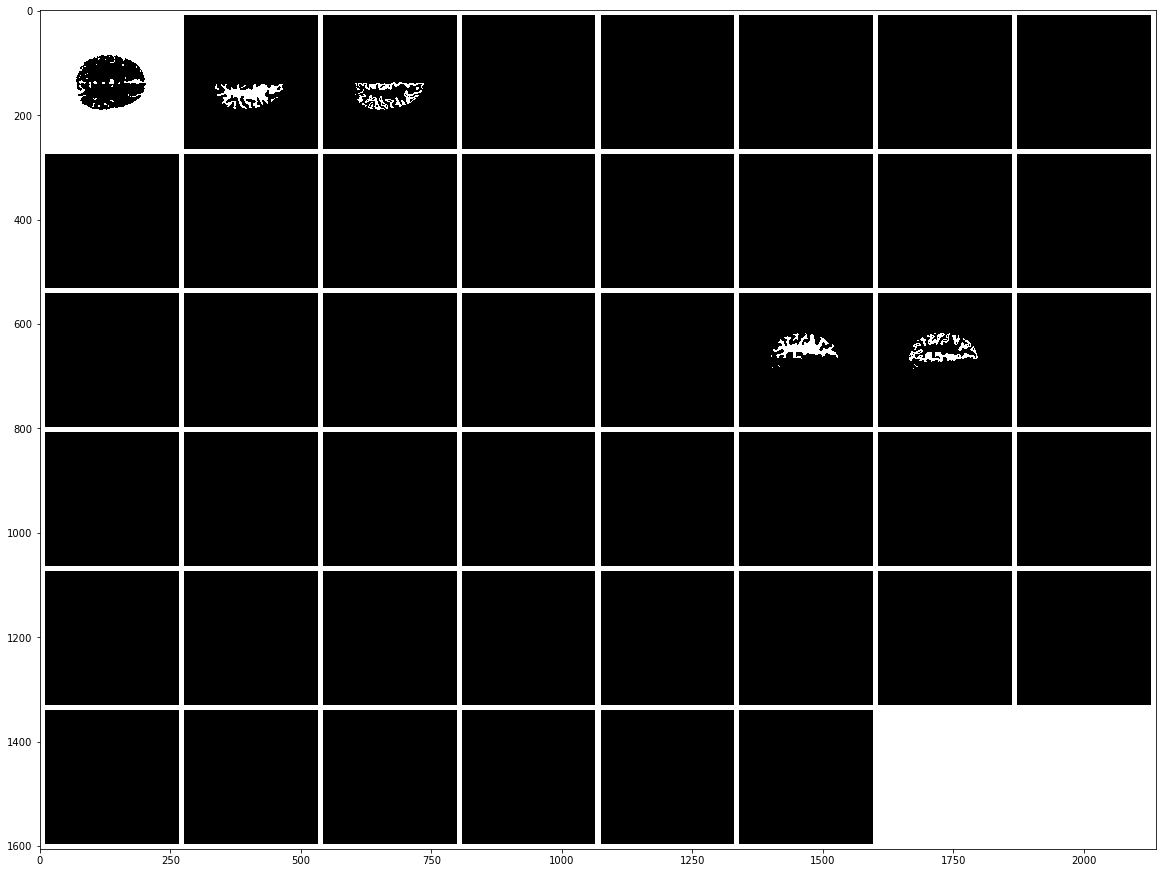

----------------------------------------------------------------------------------------------------
Ground Truth


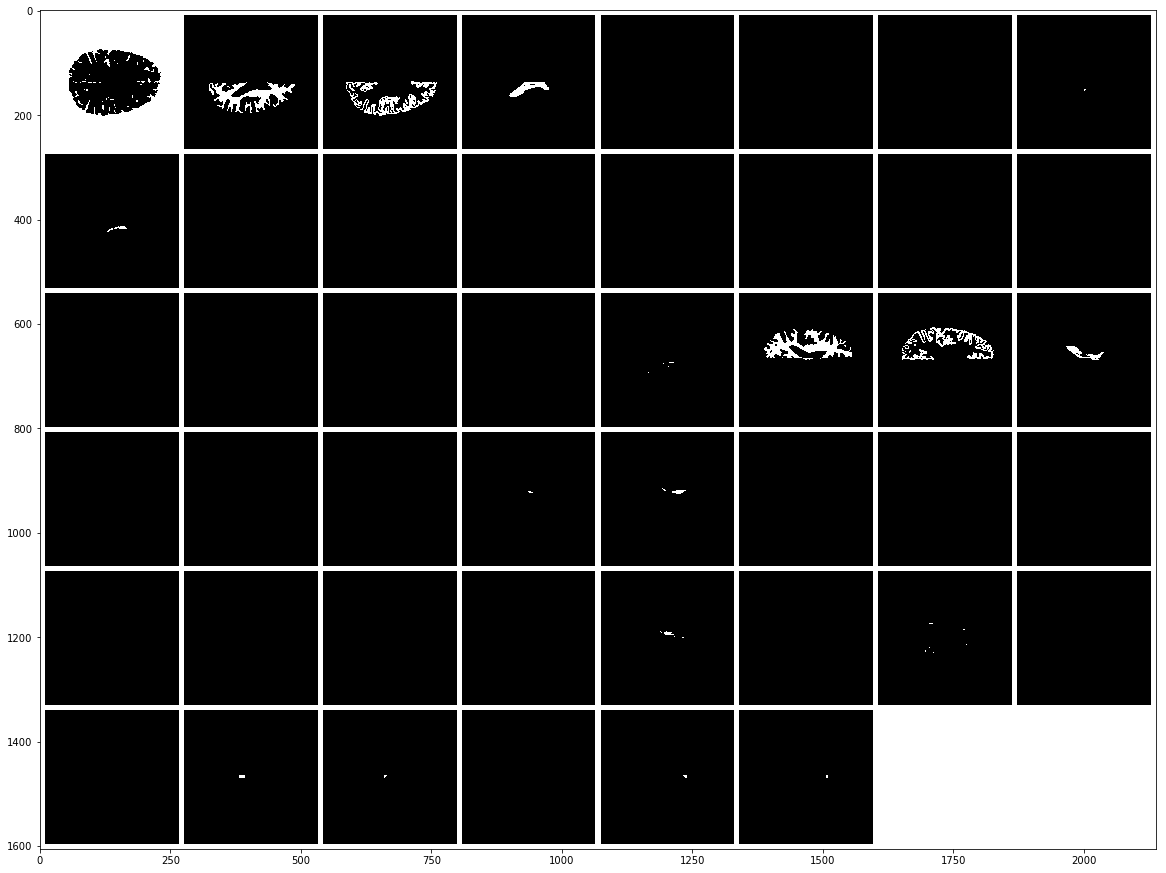

----------------------------------------------------------------------------------------------------
Prediction


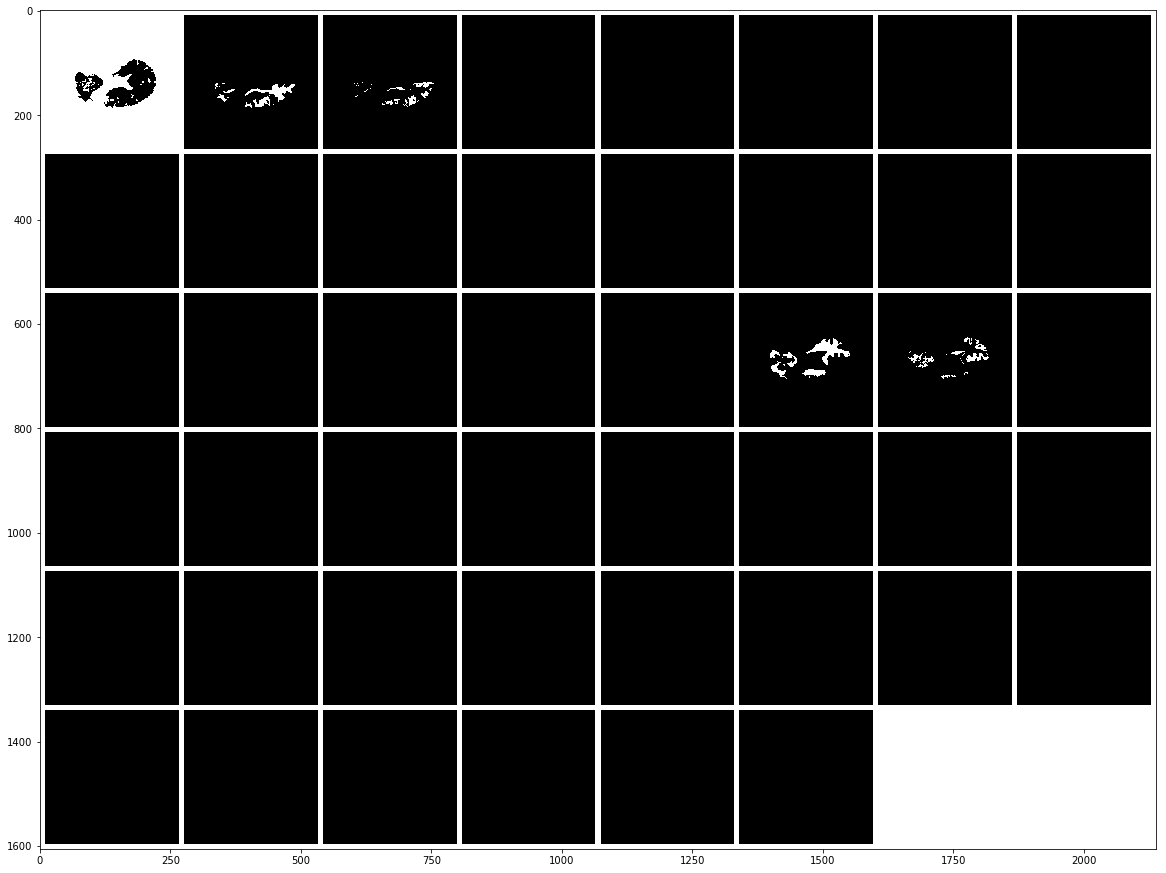

----------------------------------------------------------------------------------------------------
Ground Truth


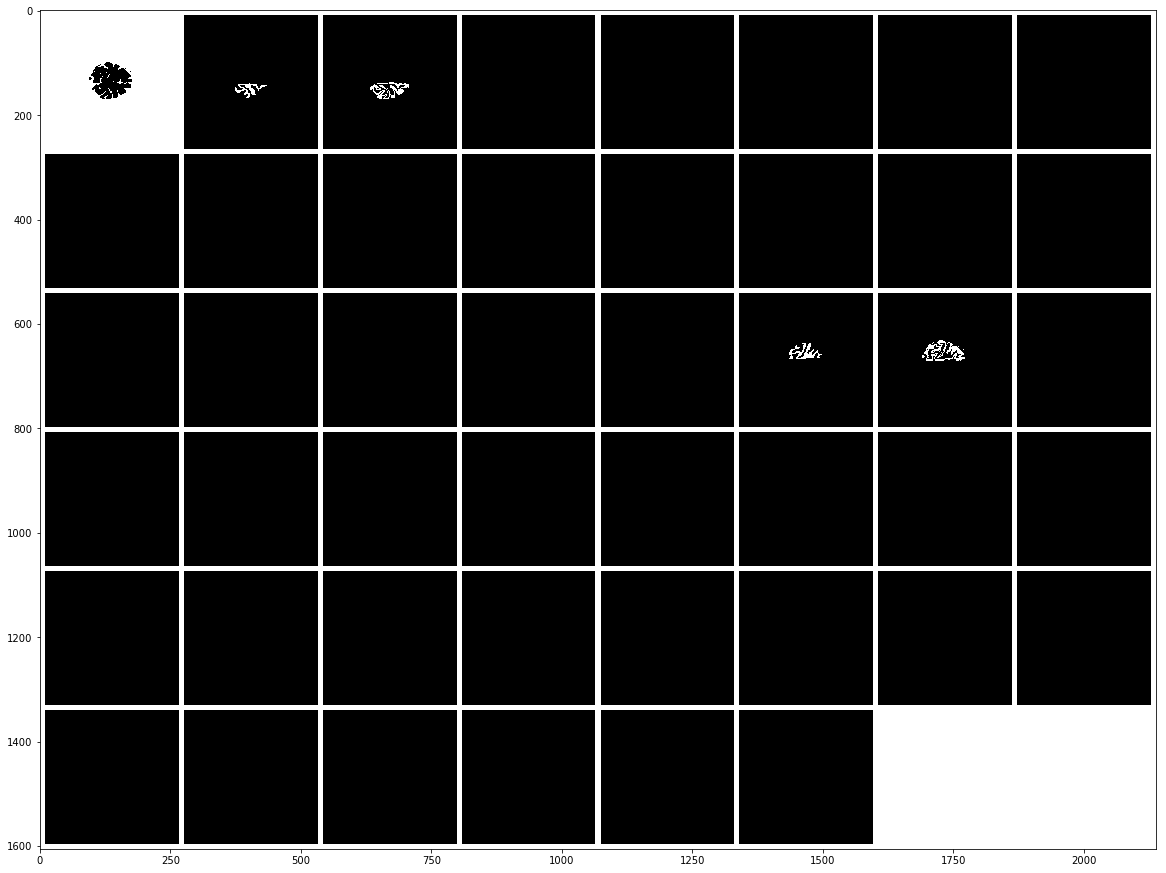

----------------------------------------------------------------------------------------------------
Prediction


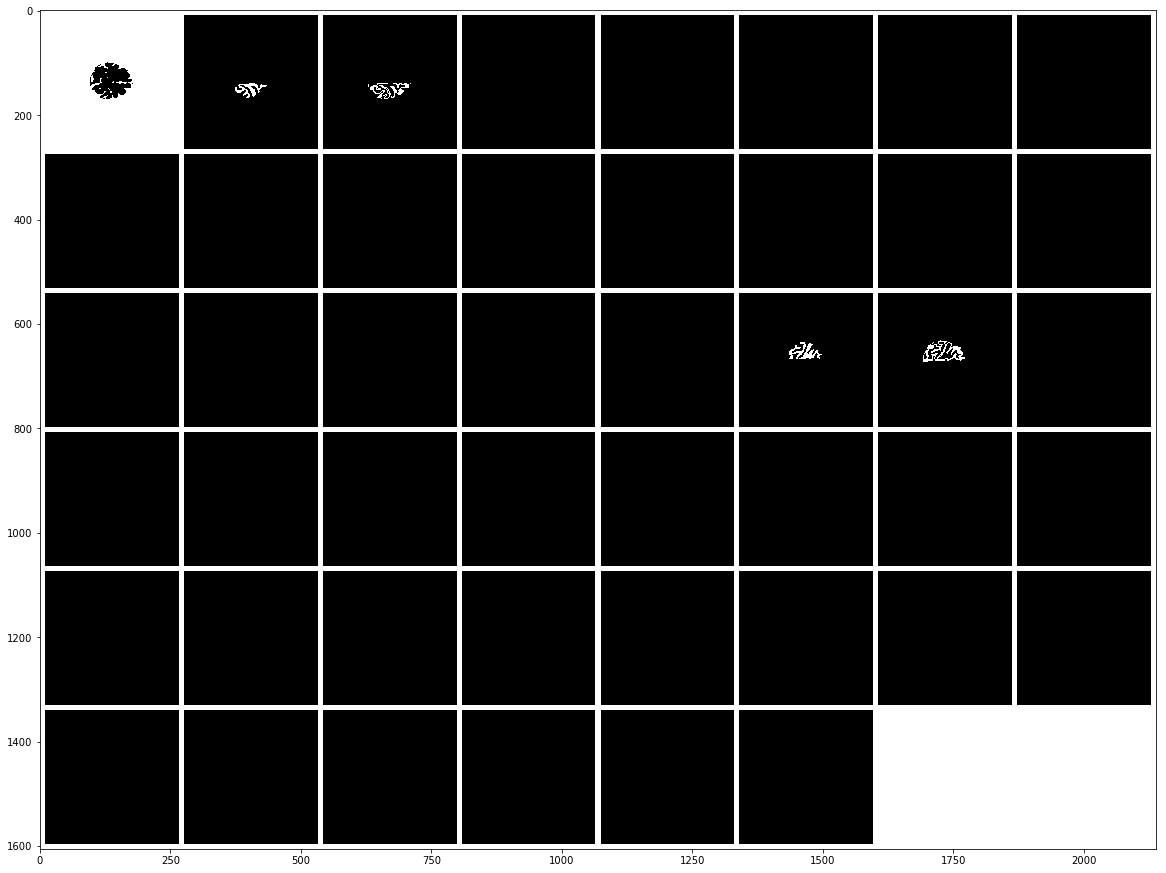

----------------------------------------------------------------------------------------------------
Ground Truth


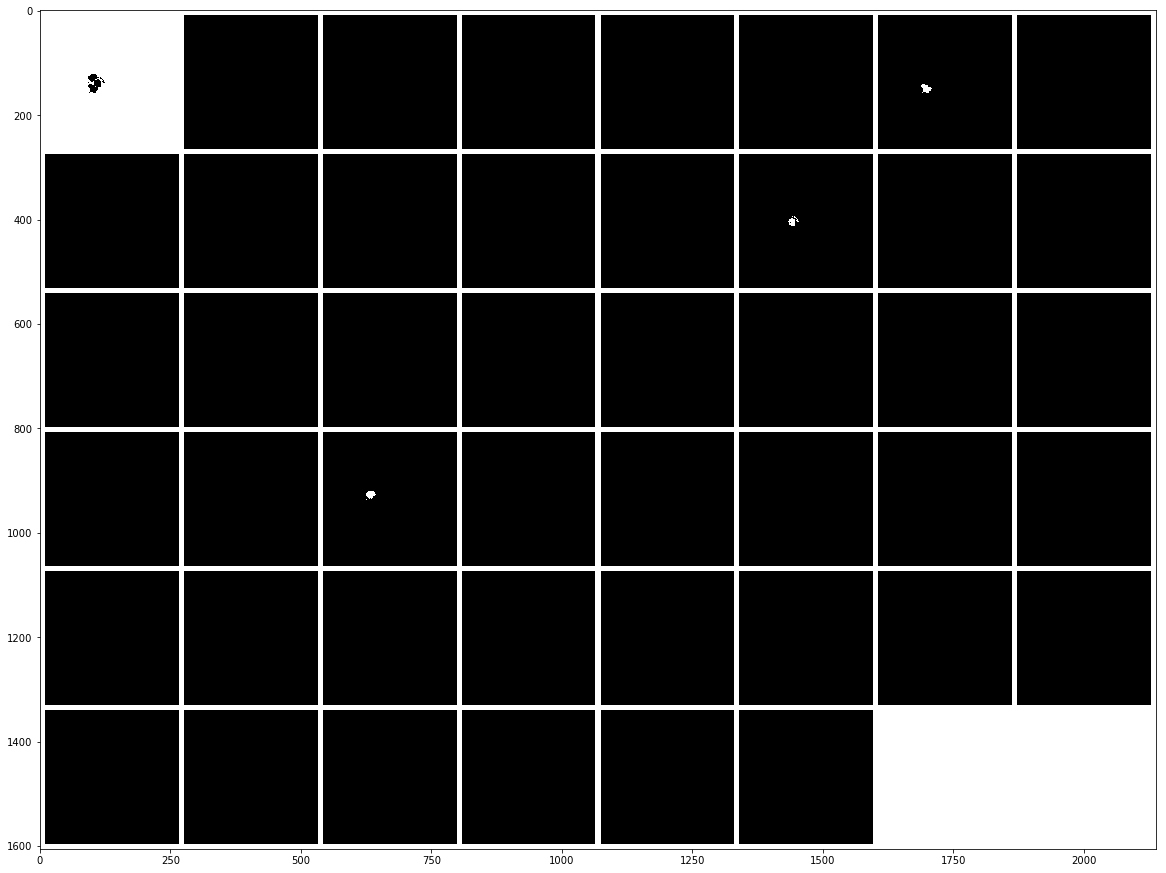

----------------------------------------------------------------------------------------------------
Prediction


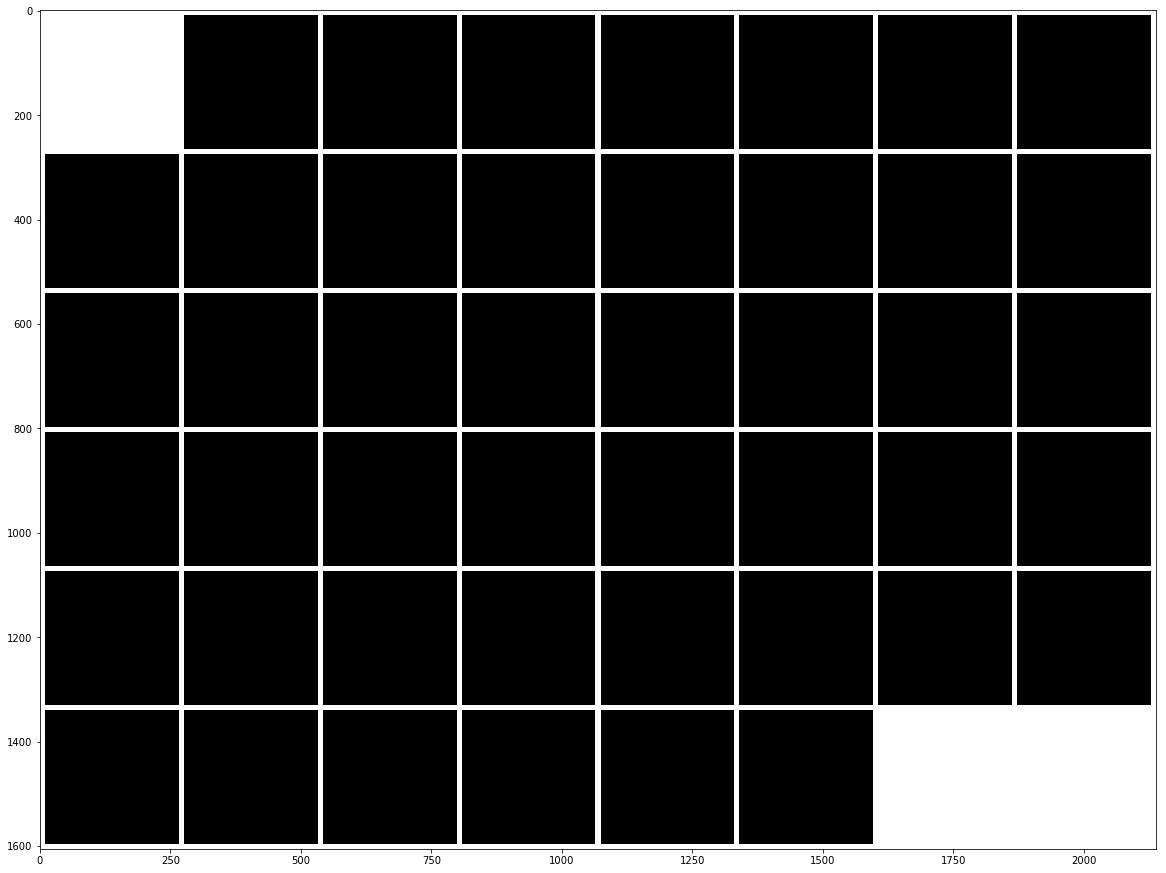

----------------------------------------------------------------------------------------------------
Ground Truth


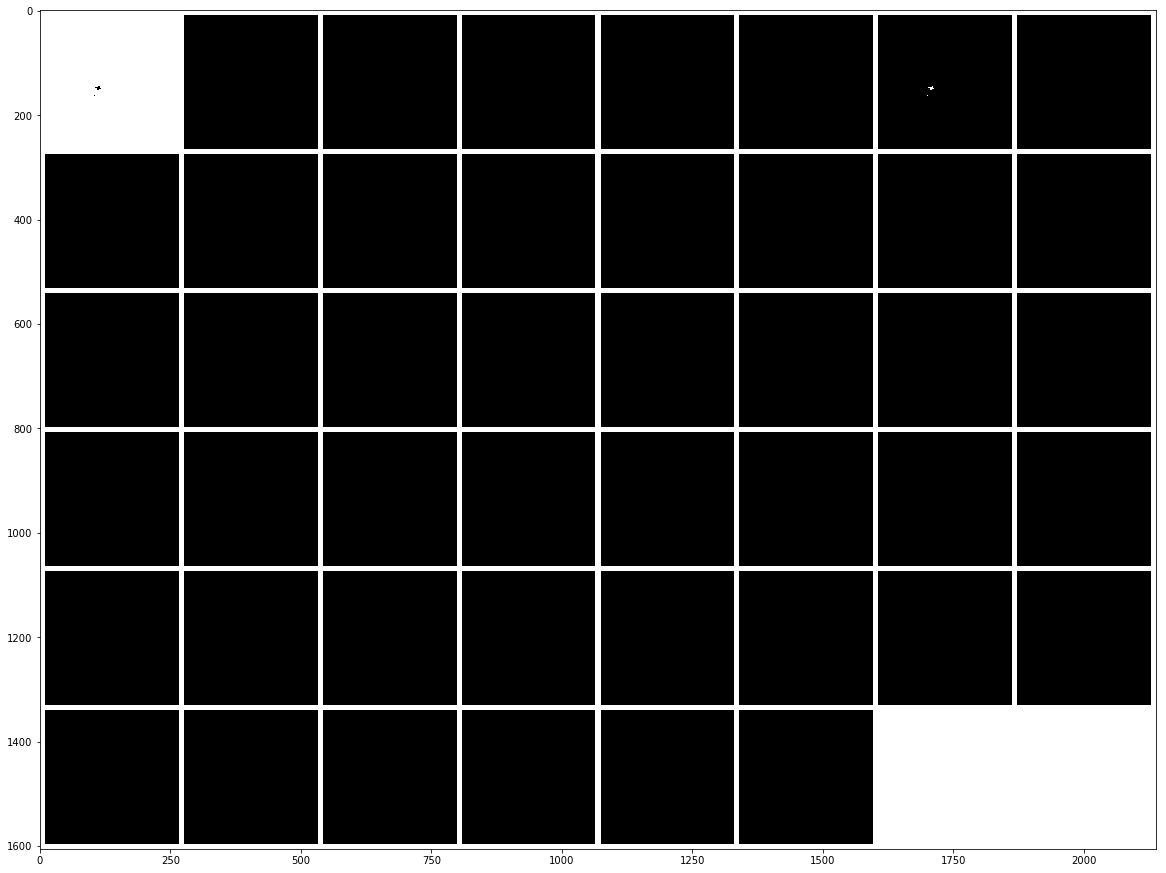

----------------------------------------------------------------------------------------------------
Prediction


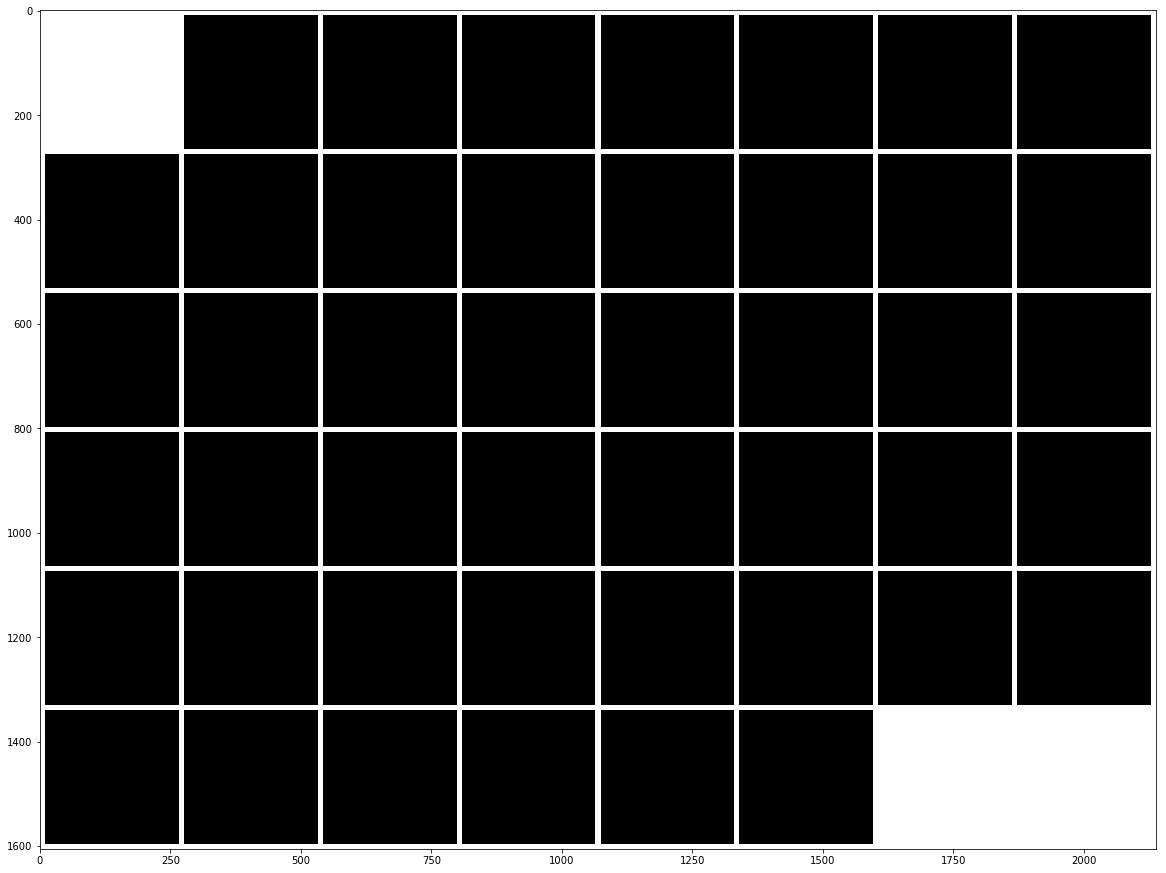

----------------------------------------------------------------------------------------------------
Ground Truth


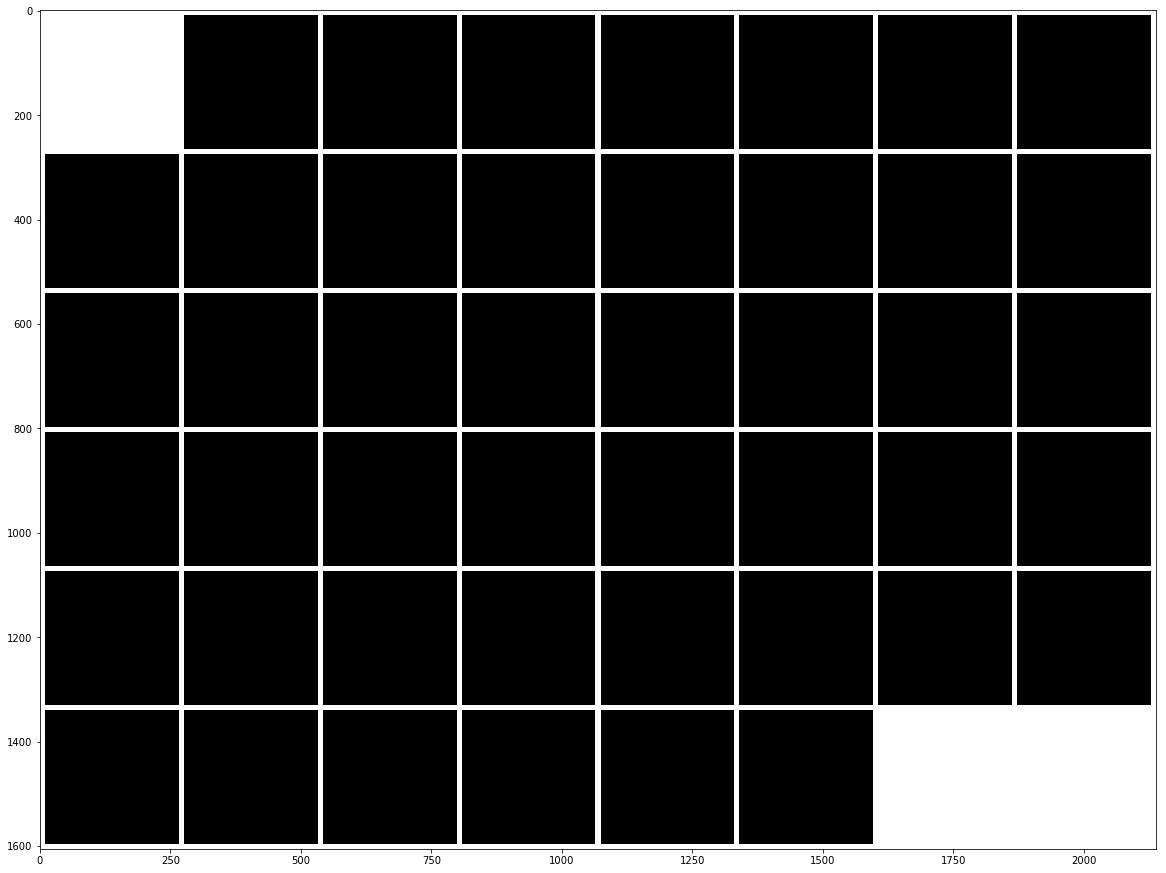

----------------------------------------------------------------------------------------------------
Prediction


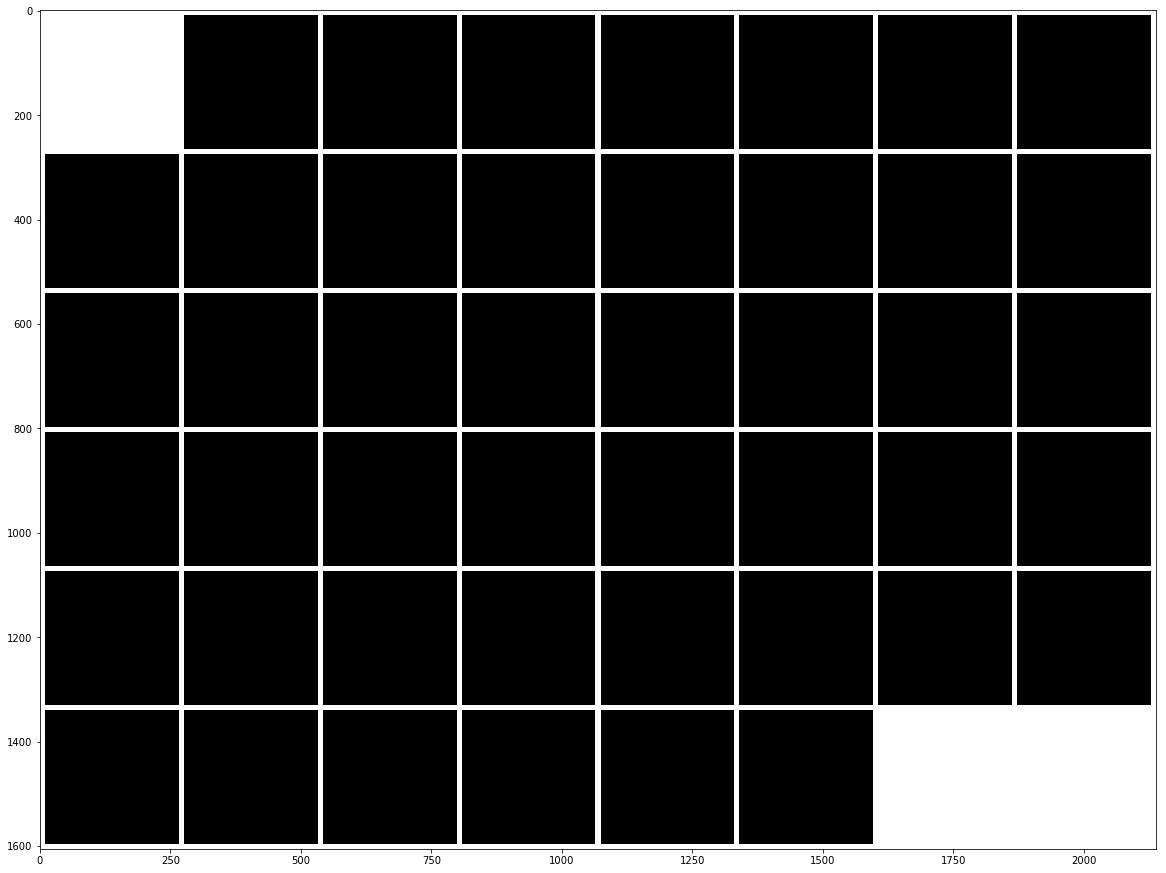

----------------------------------------------------------------------------------------------------
Ground Truth


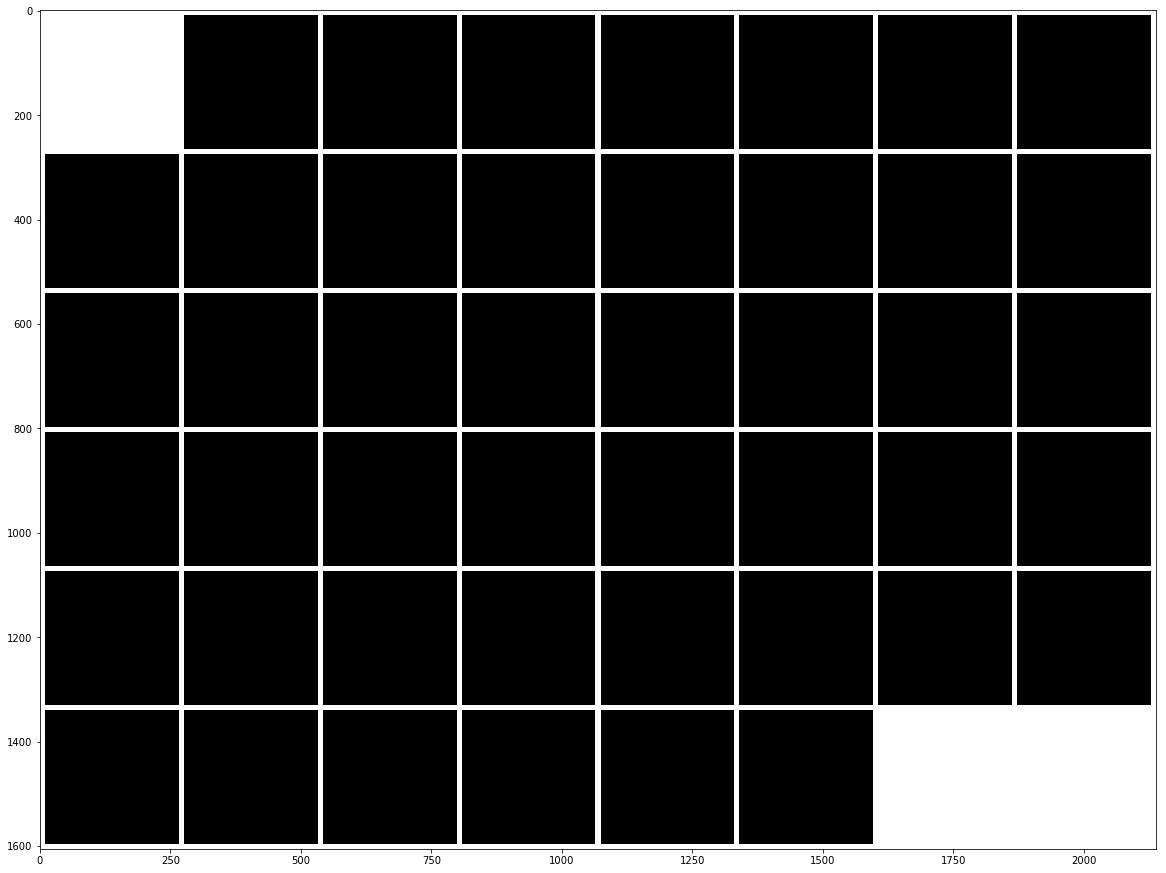

----------------------------------------------------------------------------------------------------
Prediction


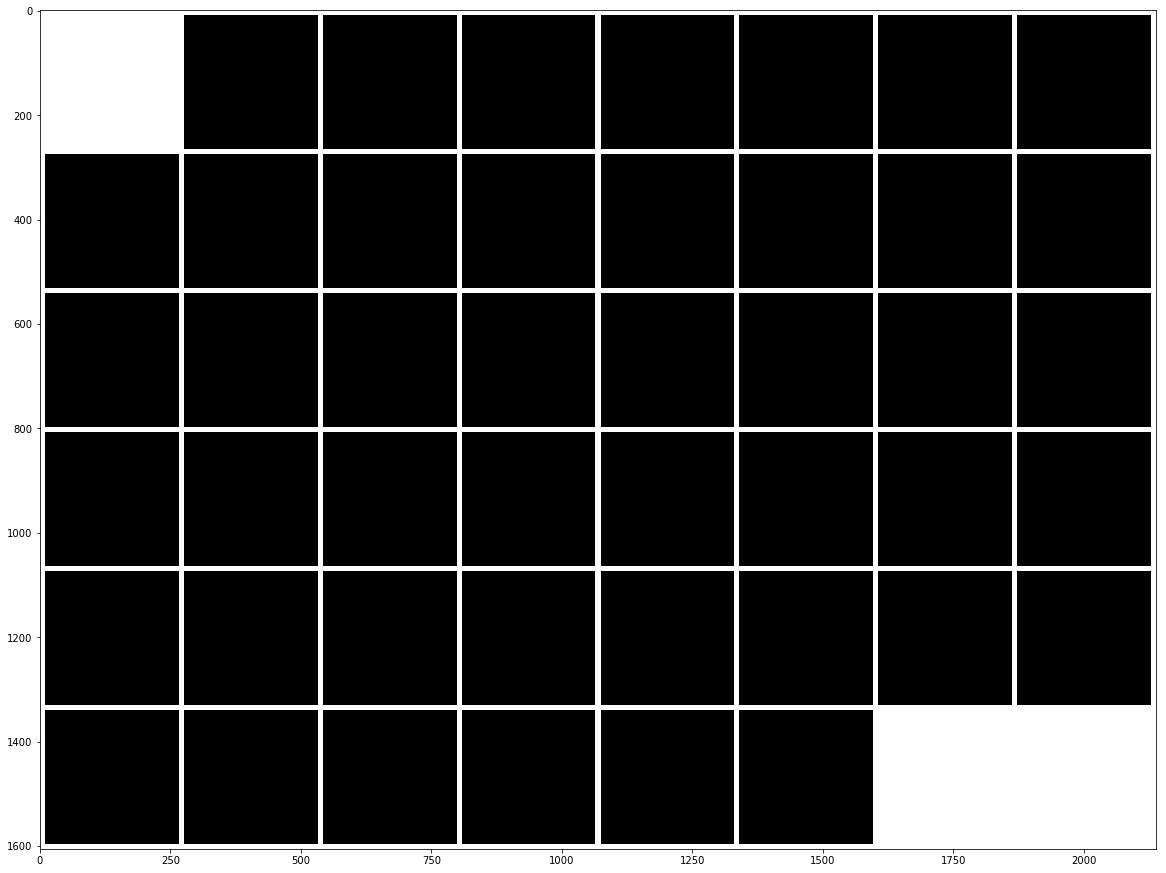

In [276]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(11):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(46,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))
    
    

In [177]:
names = []
for i in range(20):
    name = "epoch"+str(i)
    names.append(name)

In [178]:
train_dice_scores = pd.DataFrame(columns=names)
val_dice_scores = pd.DataFrame(columns=names)

In [181]:
for i in range(46):
    class_i_train = dice_hist[i]['train']
    class_i_val = dice_hist[i]['validate']
    #print(len(class_i_train))
    #print(len(class_i_val))
    train_dice_scores.loc[i] = class_i_train
    val_dice_scores.loc[i] = class_i_val

In [182]:
train_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11,epoch12,epoch13,epoch14,epoch15,epoch16,epoch17,epoch18,epoch19
0,0.86182463,0.8709584,0.9673848,0.98472536,0.98665255,0.9882434,0.99129766,0.99349225,0.9962581,0.9942993,0.99713594,0.9997197,0.9999628,0.99866724,1.0008599,1.0011163,1.0013658,1.0011016,1.0015004,1.0015235
1,0.28221262,0.46715856,0.58100003,0.63792986,0.76157,0.78842956,0.79983956,0.81116325,0.8188254,0.8156377,0.8378237,0.83817226,0.83645815,0.84051865,0.8600882,0.8586637,0.85376203,0.8561533,0.86389613,0.869213
2,0.541,0.53427386,0.5432791,0.6615918,0.69220984,0.7137785,0.7251433,0.7517074,0.7722999,0.7576339,0.790752,0.80309623,0.7995431,0.8012015,0.82583094,0.8260715,0.82479125,0.81628346,0.828699,0.8353241
3,0.90200007,0.90000004,0.90000004,0.89800006,0.90200007,0.90200007,0.90200007,0.90200007,0.90000004,0.90200007,0.90200007,0.90200007,0.90200007,0.89800006,0.90000004,0.90000004,0.90200007,0.90200007,0.90000004,0.90000004
4,0.95000005,0.952,0.952,0.952,0.952,0.952,0.952,0.95000005,0.952,0.952,0.95000005,0.952,0.952,0.952,0.952,0.952,0.952,0.952,0.952,0.952
5,0.84900004,0.851,0.851,0.851,0.85300004,0.85300004,0.85300004,0.851,0.85300004,0.851,0.84900004,0.85300004,0.85300004,0.85300004,0.85300004,0.85300004,0.85300004,0.85300004,0.85300004,0.85300004
6,0.23671491,0.777,0.77900004,0.77900004,0.77900004,0.77900004,0.781,0.777,0.781,0.77900004,0.777,0.781,0.781,0.781,0.781,0.781,0.77900004,0.781,0.77900004,0.781
7,0.919,0.91700006,0.919,0.919,0.919,0.919,0.919,0.91700006,0.91700006,0.919,0.919,0.919,0.919,0.915,0.91700006,0.919,0.919,0.919,0.91700006,0.91700006
8,0.89100003,0.88900006,0.88900006,0.887,0.89100003,0.89100003,0.89100003,0.88900006,0.88900006,0.89100003,0.89100003,0.89100003,0.89100003,0.88900006,0.88900006,0.88900006,0.89100003,0.89100003,0.88900006,0.88900006
9,0.90700006,0.90700006,0.90900004,0.90700006,0.90900004,0.90900004,0.90900004,0.90700006,0.90700006,0.90900004,0.90700006,0.90900004,0.90900004,0.90500003,0.90700006,0.90900004,0.90900004,0.90900004,0.90700006,0.90700006


In [183]:
val_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11,epoch12,epoch13,epoch14,epoch15,epoch16,epoch17,epoch18,epoch19
0,0.98174894,0.9639354,0.8069575,0.96468776,0.98931056,0.9926794,0.94051534,0.9972416,0.9645276,0.99019104,0.9650075,0.9996768,0.99479485,1.001634,0.98322415,0.999712,0.99822205,0.9881553,1.0022899,0.99437
1,0.46917975,0.57100004,0.568,0.57000005,0.76398087,0.64469665,0.3927934,0.8572428,0.5680164,0.81541824,0.5765852,0.8724833,0.8257596,0.88402987,0.69576913,0.88039005,0.846536,0.7492073,0.8922498,0.86190385
2,0.535,0.51500005,0.41050425,0.53400004,0.6938958,0.7211817,0.52637345,0.7983445,0.5340126,0.75831026,0.5459345,0.8166252,0.7908746,0.84392095,0.57364297,0.8445221,0.80831677,0.70025766,0.84771305,0.78803456
3,0.90200007,0.90300006,0.90400004,0.90400004,0.90300006,0.90200007,0.90400004,0.90400004,0.90300006,0.90200007,0.90200007,0.90300006,0.90400004,0.90200007,0.90400004,0.90200007,0.90400004,0.90400004,0.90300006,0.90000004
4,0.93600005,0.934,0.93500006,0.93600005,0.93600005,0.93600005,0.93600005,0.934,0.934,0.93600005,0.93600005,0.93500006,0.934,0.93600005,0.934,0.93600005,0.93500006,0.93600005,0.93600005,0.93500006
5,0.84800005,0.846,0.845,0.845,0.84700006,0.846,0.84700006,0.846,0.846,0.846,0.84800005,0.84700006,0.846,0.84800005,0.845,0.84800005,0.84400004,0.84700006,0.84800005,0.845
6,0.78900003,0.78700006,0.78700006,0.78700006,0.78800005,0.78800005,0.78800005,0.78800005,0.78800005,0.78800005,0.79,0.78900003,0.78800005,0.78800005,0.786,0.79,0.785,0.78900003,0.79,0.786
7,0.91800004,0.92,0.919,0.92,0.92,0.92,0.92,0.919,0.919,0.919,0.919,0.919,0.92,0.91800004,0.919,0.91800004,0.92,0.92,0.919,0.91700006
8,0.88400006,0.88500005,0.88500005,0.88600004,0.88600004,0.88500005,0.88600004,0.88500005,0.88500005,0.88400006,0.88400006,0.88500005,0.88600004,0.88400006,0.88400006,0.88400006,0.88500005,0.88600004,0.88500005,0.882
9,0.91,0.91200006,0.9110001,0.91200006,0.91200006,0.91200006,0.91200006,0.9110001,0.9110001,0.9110001,0.91200006,0.9110001,0.91200006,0.91,0.91,0.9110001,0.9110001,0.91200006,0.9110001,0.90800005
